In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import genfromtxt

## 1) Loading & Splitting Data

In [105]:
df = pd.read_csv("application_data.csv")

In [106]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [107]:
from sklearn.model_selection import train_test_split

# 75 25 splitt and standardizing data
# stratify to balance labels in train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, shuffle=True, stratify=y)

(array([70672.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6206.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

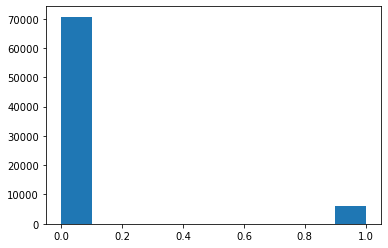

In [108]:
plt.hist(y_test)

(array([212014.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  18619.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

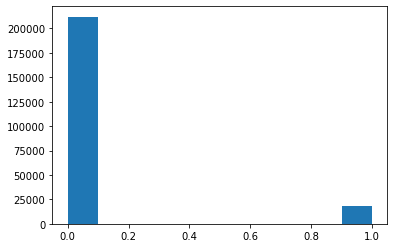

In [109]:
plt.hist(y_train)

Highly Imbalanced data!!!

## 2) Missing Data

In [110]:
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

In [111]:
percent_nan = percent_missing(df)

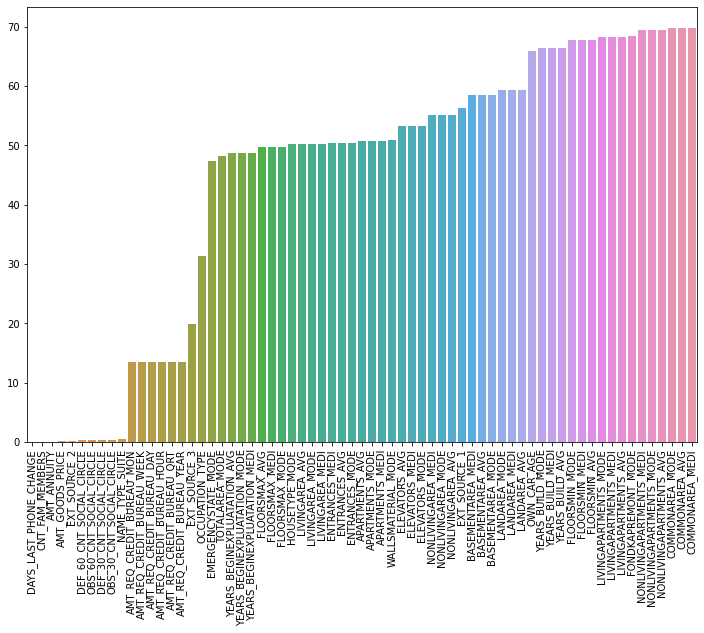

In [112]:
plt.figure(figsize=(12, 8))
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

In [113]:
# replace the missing data with mode and median values
for column in X_train:
    
    if X_train[column].dtype == np.object_:
        X_train[column].fillna(X_train[column].mode()[0], inplace=True)
    else:
        X_train[column].fillna(X_train[column].median(), inplace=True)

In [114]:
# replace the missing data with mode and median values
for column in X_test:
    
    if X_test[column].dtype == np.object_:
        X_test[column].fillna(X_test[column].mode()[0], inplace=True)
    
    else:
        X_test[column].fillna(X_test[column].median(), inplace=True)

## 3) Feature Selection

In [115]:
from sklearn.preprocessing import LabelEncoder
import pickle

for column in X_train: 
    if X_train[column].dtype == np.object_:
        le = LabelEncoder()
        X_train[column] = le.fit_transform(X_train[column])
        X_test[column] = le.transform(X_test[column])
        output = open('Data\\'+
                      column+'_encoder', 'wb')
        pickle.dump(le, output)
        output.close()

In [116]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=50)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.000580
Feature 1: 0.000864
Feature 2: 0.006939
Feature 3: 0.005862
Feature 4: 0.023859
Feature 5: 0.002232
Feature 6: 0.002708
Feature 7: 0.007087
Feature 8: 0.012180
Feature 9: 0.006233
Feature 10: 0.033765
Feature 11: 0.016382
Feature 12: 0.033827
Feature 13: 0.017000
Feature 14: 0.031795
Feature 15: 0.003441
Feature 16: 0.003948
Feature 17: 0.012593
Feature 18: 0.002001
Feature 19: 0.001738
Feature 20: 0.024226
Feature 21: 0.048037
Feature 22: 0.032285
Feature 23: 0.001085
Feature 24: 0.047500
Feature 25: 0.004398
Feature 26: 0.000353
Feature 27: 0.015179
Feature 28: 0.015532
Feature 29: 0.028726
Feature 30: 0.029566
Feature 31: 0.007504
Feature 32: 0.003923
Feature 33: 0.000020
Feature 34: 0.000256
Feature 35: 0.000000
Feature 36: 0.001590
Feature 37: 0.004226
Feature 38: 0.002727
Feature 39: 0.007111
Feature 40: 0.016426
Feature 41: 0.011232
Feature 42: 0.013931
Feature 43: 0.002475
Feature 44: 0.001877
Feature 45: 0.008802
Feature 46: 0.014550
Feature 47: 0.001314
Fe

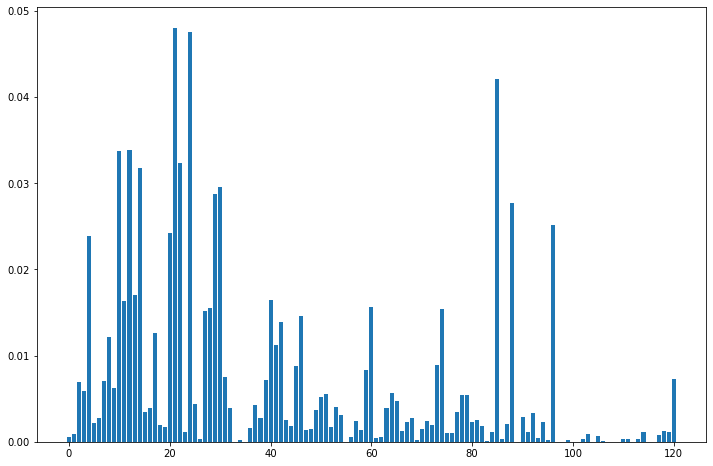

In [117]:
# plot the scores
plt.figure(figsize=(12, 8))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## 4) Oversampling

In [118]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train_os, y_train_os = oversample.fit_resample(X_train_fs, y_train)

In [119]:
y_train_os.value_counts()

0    212014
1    212014
Name: TARGET, dtype: int64

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_os = scaler.fit_transform(X_train_os)
X_test_fs = scaler.transform(X_test_fs)

## 5) Model Development with Hyperparameter Tuning

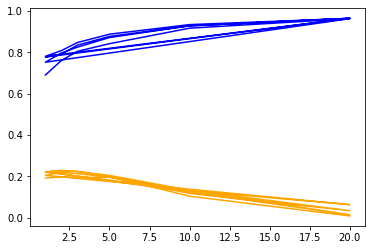

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# finding the hyperparameters to avoid overfitting
param_grid = {
    "n_estimators": [5, 10, 20, 50],
    "max_depth": [1, 2, 3, 5, 10, 20],
}
result_dic = {
    "n_estimators": [],
    "max_depth": [],
    "train_f1": [],
    "test_f1": []
}
for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
    
        rf_model = RandomForestClassifier(n_estimators=n_est,
                                             criterion='entropy',
                                             max_depth=depth,
                                             random_state=1)
        rf_model.fit(X_train_os, y_train_os)
        y_pred = rf_model.predict(X_train_os)  
        predictions = rf_model.predict(X_test_fs)  

        f1_train = f1_score(y_pred, y_train_os)
        f1_test = f1_score(y_test, predictions)

        result_dic['n_estimators'].append(n_est)
        result_dic['max_depth'].append(depth)
        result_dic['train_f1'].append(f1_train)
        result_dic['test_f1'].append(f1_test)
    
plt.plot(result_dic['max_depth'], result_dic['train_f1'], c='blue')
plt.plot(result_dic['max_depth'], result_dic['test_f1'], c='orange')

## 6) Model Evaluation

In [174]:
from sklearn.metrics import confusion_matrix

rf_model = RandomForestClassifier(n_estimators=20,
                                     criterion='entropy',
                                     max_depth=2,
                                     random_state=1)

rf_model.fit(X_train_os, y_train_os) 

y_pred = rf_model.predict(X_train_os)
predictions = rf_model.predict(X_test_fs)  

In [176]:
conf_mat_test = confusion_matrix(y_test, predictions)
conf_mat_test

array([[56451, 14221],
       [ 3598,  2608]], dtype=int64)

In [180]:
from sklearn.metrics import classification_report

In [182]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     70672
           1       0.15      0.42      0.23      6206

    accuracy                           0.77     76878
   macro avg       0.55      0.61      0.55     76878
weighted avg       0.88      0.77      0.81     76878



## 7) Optimum Threshold

In [193]:
# Searching for the best probability threshold
probs_1 = rf_model.predict_proba(X_test_fs)[:, 1]
thresholds = np.arange(0, 1.05, 0.05)
result_dic = {
'f1_scores' : [],
'thresholds' : []
}
predictions_new = [] 

for thresh in thresholds:
    for prob in probs_1:
        if prob >= thresh:
            predictions_new.append(1)
        else:
            predictions_new.append(0)
    f1 = f1_score(y_test, predictions_new)
    result_dic['f1_scores'].append(f1)
    result_dic['thresholds'].append(thresh)
    predictions_new = []

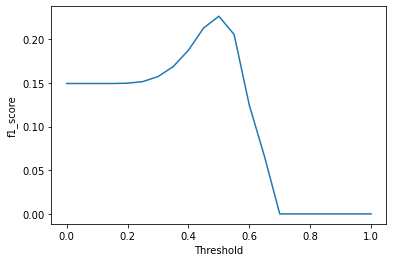

In [196]:
plt.xlabel('Threshold')
plt.ylabel('f1_score')
plt.plot(result_dic['thresholds'], result_dic['f1_scores'])

## 8) Feature Importance

In [200]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [202]:
rf_model = RandomForestClassifier(n_estimators=20,
                                     criterion='entropy',
                                     max_depth=2,
                                     random_state=1)

rf_model.fit(X_train_os, y_train_os) 

y_pred = rf_model.predict(X_train_os)
predictions = rf_model.predict(X_test)  

In [218]:
df_importance = pd.DataFrame(index=X_test.columns, data=rf_model.feature_importances_, columns=['importances'])

In [219]:
df_importance.sort_values('importances', ascending=True, inplace=True)

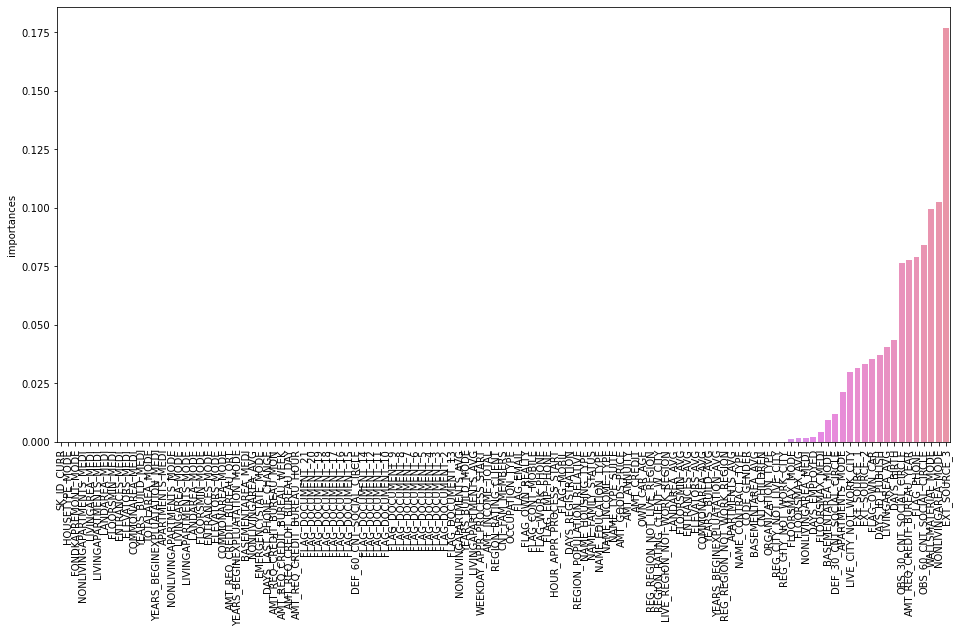

In [220]:
plt.figure(figsize=(16, 8))
sns.barplot(x=df_importance.index,y=df_importance['importances'])
plt.xticks(rotation=90);

In [223]:
df_importance.tail(10)

,importances
DAYS_ID_PUBLISH,0.037138
LIVINGAREA_AVG,0.040361
DAYS_BIRTH,0.043331
OBS_30_CNT_SOCIAL_CIRCLE,0.076596
AMT_REQ_CREDIT_BUREAU_YEAR,0.077500
FLAG_PHONE,0.078829
OBS_60_CNT_SOCIAL_CIRCLE,0.084234
WALLSMATERIAL_MODE,0.099608
NONLIVINGAREA_MODE,0.102456
EXT_SOURCE_3,0.177042


## 9) Model Development with Most Important Features

In [229]:
X_train_10 = X_train[df_importance.tail(10).index]
X_test_10 = X_test[df_importance.tail(10).index]

from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train_10, y_train_10 = oversample.fit_resample(X_train_10, y_train)

from sklearn.metrics import confusion_matrix

rf_model = RandomForestClassifier(n_estimators=20,
                                     criterion='entropy',
                                     max_depth=2,
                                     random_state=1)

rf_model.fit(X_train_10, y_train_10) 

y_pred = rf_model.predict(X_train_10)
predictions = rf_model.predict(X_test_10)  

In [235]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     70672
           1       0.11      0.44      0.17      6206

    accuracy                           0.65     76878
   macro avg       0.52      0.56      0.47     76878
weighted avg       0.87      0.65      0.73     76878

